In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import flopy
from flopy.discretization import StructuredGrid, VertexGrid
from flopy.utils.triangle import Triangle
from flopy.utils.voronoi import VoronoiGrid
from flopy.utils.gridgen import Gridgen
import flopy.plot.styles as styles

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/Users/langevin/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
temp_path = './temp'
if not os.path.isdir(temp_path):
    os.mkdir(temp_path)

# Configure Plot Settings

In [5]:
figwidth = 90 # mm
figwidth = figwidth / 10 / 2.54 # inches
figheight = figwidth
figsize = (figwidth, figheight)

In [6]:
extent = [0.0, 9450.0, 0.0, 6900.0]
ixiy = [(0, 2), (1, 2), (1, 3), (0, 3)]
domainpoly = [(extent[ix], extent[iy]) for ix, iy in ixiy]
domainpoly = Polygon(domainpoly)
xmin, ymin, xmax, ymax = domainpoly.bounds

9450.0 6900.0 69 94


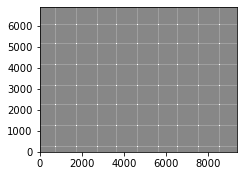

In [7]:
# Create a regular MODFLOW grid
Lx = xmax - xmin
Ly = ymax - ymin
dx = dy = 100
nrow = int(Ly / dy)
ncol = int(Lx / dx)
print(Lx, Ly, nrow, ncol)
delr = np.array(ncol * [dx])
delc = np.array(nrow * [dy])
regular_grid = StructuredGrid(delr=delr, delc=delc, xoff=xmin, yoff=ymin)

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot()
ax.set_aspect('equal')
regular_grid.plot(ax=ax)

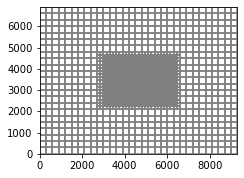

In [8]:
# quadtree grid
sim = flopy.mf6.MFSimulation()
gwf = gwf = flopy.mf6.ModflowGwf(sim)
dx = dy = 300.
nr = int(Ly / dy)
nc = int(Lx / dx)
dis6 = flopy.mf6.ModflowGwfdis(
    gwf,
    nrow=nr,
    ncol=nc,
    delr=dy,
    delc=dx,
)
g = Gridgen(dis6, model_ws=temp_path)
xrmin = xmin + .33 * Lx
xrmax = xmax - .33 * Lx
yrmin = ymin + .33 * Ly
yrmax = ymax - .33 * Ly

adpoly = [[[(xrmin, yrmin), (xrmax, yrmin), (xrmax, yrmax), 
            (xrmin, yrmax), (xrmin, yrmin)]]]
g.add_refinement_features(adpoly, 'polygon', 2, range(1))
g.build(verbose=False)

gridprops_vg = g.get_gridprops_vertexgrid()
quadtree_grid = flopy.discretization.VertexGrid(**gridprops_vg)

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot()
ax.set_aspect('equal')
quadtree_grid.plot(ax=ax)

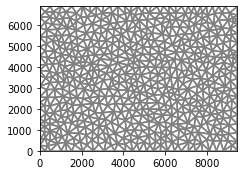

In [9]:
# Set maximum cell area
maximum_area = dx * dy

tri = Triangle(maximum_area=maximum_area, angle=30, model_ws=temp_path)
poly = np.array(((xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)))
tri.add_polygon(poly)
tri.build(verbose=False)
cell2d = tri.get_cell2d()
vertices = tri.get_vertices()
triangular_grid = VertexGrid(vertices=vertices, cell2d=cell2d)

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot()
ax.set_aspect('equal')
triangular_grid.plot(ax=ax)

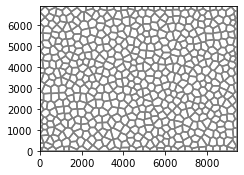

In [10]:
tri = Triangle(maximum_area=maximum_area, angle=30, model_ws=temp_path)
poly = np.array(((xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)))
tri.add_polygon(poly)
tri.build(verbose=False)

# create vor object and VertexGrid
vor = VoronoiGrid(tri.verts)
gridprops = vor.get_gridprops_vertexgrid()
voronoi_grid = VertexGrid(**gridprops, nlay=1, xoff=xmin, yoff=ymin)

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot()
ax.set_aspect('equal')
voronoi_grid.plot(ax=ax)

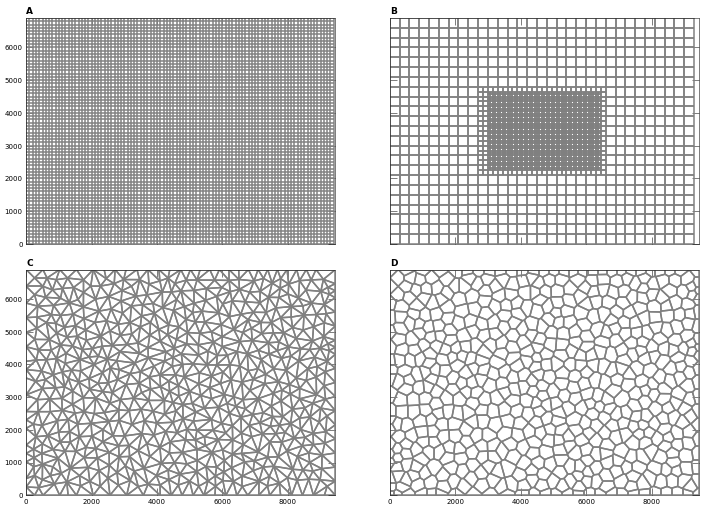

In [11]:
# Make a plot of the four grids
figwidth = 10
figheight = 7
grids = [regular_grid, quadtree_grid, triangular_grid, voronoi_grid]

with styles.USGSMap():
    fig, axs = plt.subplots(nrows=2, ncols=2, 
                            sharex=True, sharey=True, 
                            figsize=(figwidth, figheight), 
                            constrained_layout=True)

    idx = 0
    g = grids[idx]
    ax = axs[0][0]
    regular_grid.plot(ax=ax)
    ax.set_aspect('equal')
    styles.heading(ax, idx=idx)

    idx = 1
    g = grids[idx]
    ax = axs[0][1]
    quadtree_grid.plot(ax=ax)
    ax.set_aspect('equal')
    styles.heading(ax, idx=idx)

    idx = 2
    g = grids[idx]
    ax = axs[1][0]
    triangular_grid.plot(ax=ax)
    ax.set_aspect('equal')
    styles.heading(ax, idx=idx)

    idx = 3
    g = grids[idx]
    ax = axs[1][1]
    voronoi_grid.plot(ax=ax)
    ax.set_aspect('equal')
    styles.heading(ax, idx=idx)

    if True:
        fpth = os.path.join("..", "doc", "figures", "grids.png")
        plt.savefig(fpth, dpi=300);